In [31]:
# python
import logging_utils.formatter_logging as log
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from storage_utils.patients_data_new import patients
import os
from biosppy.signals import ecg
import matplotlylib as pltly

In [32]:
# import from filtering folder
from Preprocessing import filtering as filt

In [33]:
# File path and read mode, I/O cache specs

# hdf5 file
disk='/mnt/Seagate/'
files_dir = 'h5_files_backup/processing_datasets/'
file_name = 'seizure_datasets_new.h5'
file_path = disk + files_dir + file_name

f = h5py.File(file_path, 'a')

In [34]:
# Get seizure dataset ID, Patient Number (Primary Key)
# and seizure Number (Secondary)
patient_number=3
seizure_number=0

# Get Hospital Info on seizure dataset
patient_info = patients[str(patient_number)]
patient_info

{'ECG leads': ['Ecg', 'ECG-'],
 'age': 55,
 'dates_of_seizure': [datetime.date(2017, 4, 20),
  datetime.date(2017, 4, 20),
  datetime.date(2017, 4, 20)],
 'ictal_clinical_on_time': [datetime.time(8, 25, 44),
  datetime.time(16, 42, 53),
  datetime.time(21, 45, 12)],
 'ictal_on_time': [datetime.time(8, 25, 41),
  datetime.time(16, 41, 35),
  datetime.time(21, 43, 55)],
 'lateralization_onset': ['RL', 'L'],
 'location': ['FTl,Tl-FTr,Tr', 'FTl,Tl', 'Fl,Tl'],
 'post_ictal_time': [datetime.time(8, 26, 27),
  datetime.time(16, 45, 14),
  datetime.time(21, 46, 12)],
 'sex': 'f',
 'types_of_seizure': ['G-A-M', 'F-NA-M', 'F-A-M']}

In [35]:
# Get necessary input feature datasets

# feature of analysis (INPUT)
feature_name=('signals/3000_1200'
              '/raw')

seizures = f[feature_name].keys()

# get seizures from patient
seizure_from_patient = [seizure
                         for seizure in seizures
                         if seizure.split('_')[0] == str(patient_number)
                         ]

seizure_name = seizure_from_patient[seizure_number]

# Get hdf dataset
seizure_hdfdataset = f[feature_name + '/' + seizure_name]
time_domain_hdfdataset = f[feature_name + '/' + 'time_domain_' + seizure_name]

# load the datasets to memory
seizure_dataset = seizure_hdfdataset[:]
time_domain = time_domain_hdfdataset[:]

# Load the array into unidimensional signal, since it is unidimensional ECG
raw_ecg = seizure_dataset
raw_time_sec = time_domain

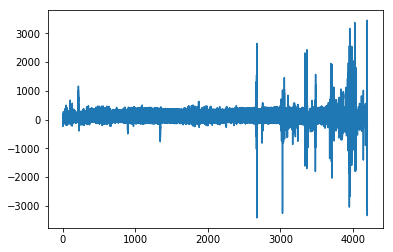

In [6]:
# Test correct input by ploting
plt.figure()
plt.plot(raw_time_sec, raw_ecg)
plt.show()

In [22]:
# State Hyper Parameters of feature extraction (Transformation)
sampling_rate=1000

In [23]:
# Apply Median Filter and subsequent Low-pass FIR

medianFIR_ecg = filt.create_filtered_dataset(raw_ecg, filtmethod='medianFIR',
                                             sampling_rate=sampling_rate)
medianFIR_ecg_time_sec = raw_time_sec

Baseline_removal
done


In [36]:
# Apply pre-defined structure for ETL pipeline (OUTPUT) 

# Allocate feature space name
medianFIR_name = feature_name + '/' + 'MedianFIR'
feature_name_for_struct = 'MedianFIR' 

# Allocate seizure dataset name
seizure_dataset_name = medianFIR_name + '/' + seizure_name
time_domain_seizure_dataset_name = medianFIR_name + '/' + 'time_window_' + seizure_name

# Restructure the dataset
median_FIR_feature_array = np.asarray([medianFIR_ecg])

# Cache data to disk, in the same hdffile: Overwrites by default
try:
    print 'Deleting: {}'.format(seizure_dataset_name) 
    del f[seizure_dataset_name]

except Exception as e:
    print e
    
try:
    print 'Deleting: {}'.format(time_window_seizure_dataset_name) 
    del f[time_domain_seizure_dataset_name]

except Exception as e:
    print e
    print 'Could Not Delete! the time window'
    
# Save datasets to disk

print 'Saving the datasets...'
dset = f.create_dataset(seizure_dataset_name,
                        data=median_FIR_feature_array)
time_dset = f.create_dataset(time_domain_seizure_dataset_name, 
                             data=medianFIR_ecg_time_sec)
print 'Done !'

# add metadata
dset.attrs['feature_legend'] = feature_name_for_struct
time_dset.attrs['feature_legend'] = feature_name_for_struct

Deleting: signals/3000_1200/raw/MedianFIR/3_FA7774DK_2017-04-20 07:38:44.000000_0
"Couldn't delete link (component not found)"
name 'time_window_seizure_dataset_name' is not defined
Could Not Delete! the time window


In [37]:
f.close()